In [1]:
import sae_lens
import torch
import jaxtyping
import random
import datasets
import plotly.colors as pc
import plotly.express as px
import seaborn as sns
import numpy as np
import pandas as pd
from typing import List, Tuple
from tqdm import tqdm

def obtain_data() -> (
    Tuple[List[sae_lens.SAE], torch.nn.Module, torch.utils.data.Dataset]
):
    """
    load sae, model and dataset
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    layers = 6
    saes = []
    release = "pythia-70m-deduped-res-sm"
    model_name = "pythia-70m-deduped"
    for layer in tqdm(range(layers)):
        sae_id = f"blocks.{layer}.hook_resid_post"
        saes.append(
            sae_lens.SAE.from_pretrained(release=release, sae_id=sae_id, device=device)[
                0
            ]
        )

    model = sae_lens.HookedSAETransformer.from_pretrained(model_name)
    # ds = datasets.load_dataset("Salesforce/wikitext", "wikitext-2-raw-v1")["train"]

    return saes, model, _

saes, model, ds = obtain_data()
code_acts = torch.load("../res/acts/BAAI-TACO-pythia70m-res-all6-acts.pt")
math_acts = torch.load("../res/acts/math-pythia70m-res-all6-acts.pt")
wiki_acts = torch.load("../res/acts/wiki-pythia70m-res-all6-acts.pt")

/mnt/c/Users/huohu/Documents/code/SAEGeometry/config/saegeometry-1tp4usyN-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 6/6 [00:02<00:00,  2.01it/s]
The `GPTNeoXSdpaAttention` class is deprecated in favor of simply modifying the `config._attn_implementation`attribute of the `GPTNeoXAttention` class! It will be removed in v4.48


Loaded pretrained model pythia-70m-deduped into HookedTransformer


/tmp/ipykernel_27065/2589476906.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  code_acts = torch.load("../res/acts/BAAI-TACO-pythia70m-res-all6-acts.pt")
/tmp/ipykerne

In [2]:
@torch.no_grad()
def get_cosine_similarity(
    dict_elements_1: jaxtyping.Float[torch.Tensor, "d_sae d_llm"],
    dict_elements_2: jaxtyping.Float[torch.Tensor, "d_sae d_llm"],
    p: int = 2,
    dim: int = 1,
    normalized: bool = True,
) -> jaxtyping.Float[torch.Tensor, "d_llm d_llm"]:
    """Get the cosine similarity between the dictionary elements.

    Args:
        dict_elements_1: The first dictionary elements.
        dict_elements_2: The second dictionary elements.

    Returns:
        The cosine similarity between the dictionary elements.
    """
    # Compute cosine similarity in pytorch
    dict_elements_1 = dict_elements_1
    dict_elements_2 = dict_elements_2

    # Normalize the tensors
    if normalized:
        dict_elements_1 = torch.nn.functional.normalize(dict_elements_1, p=p, dim=dim)
        dict_elements_2 = torch.nn.functional.normalize(dict_elements_2, p=p, dim=dim)

    # Compute cosine similarity using matrix multiplication
    cosine_sim: jaxtyping.Float[torch.Tensor, "d_sae d_sae"] = torch.mm(
        dict_elements_1, dict_elements_2.T
    )
    # max_cosine_sim, _ = torch.max(cosine_sim, dim=1)
    return cosine_sim

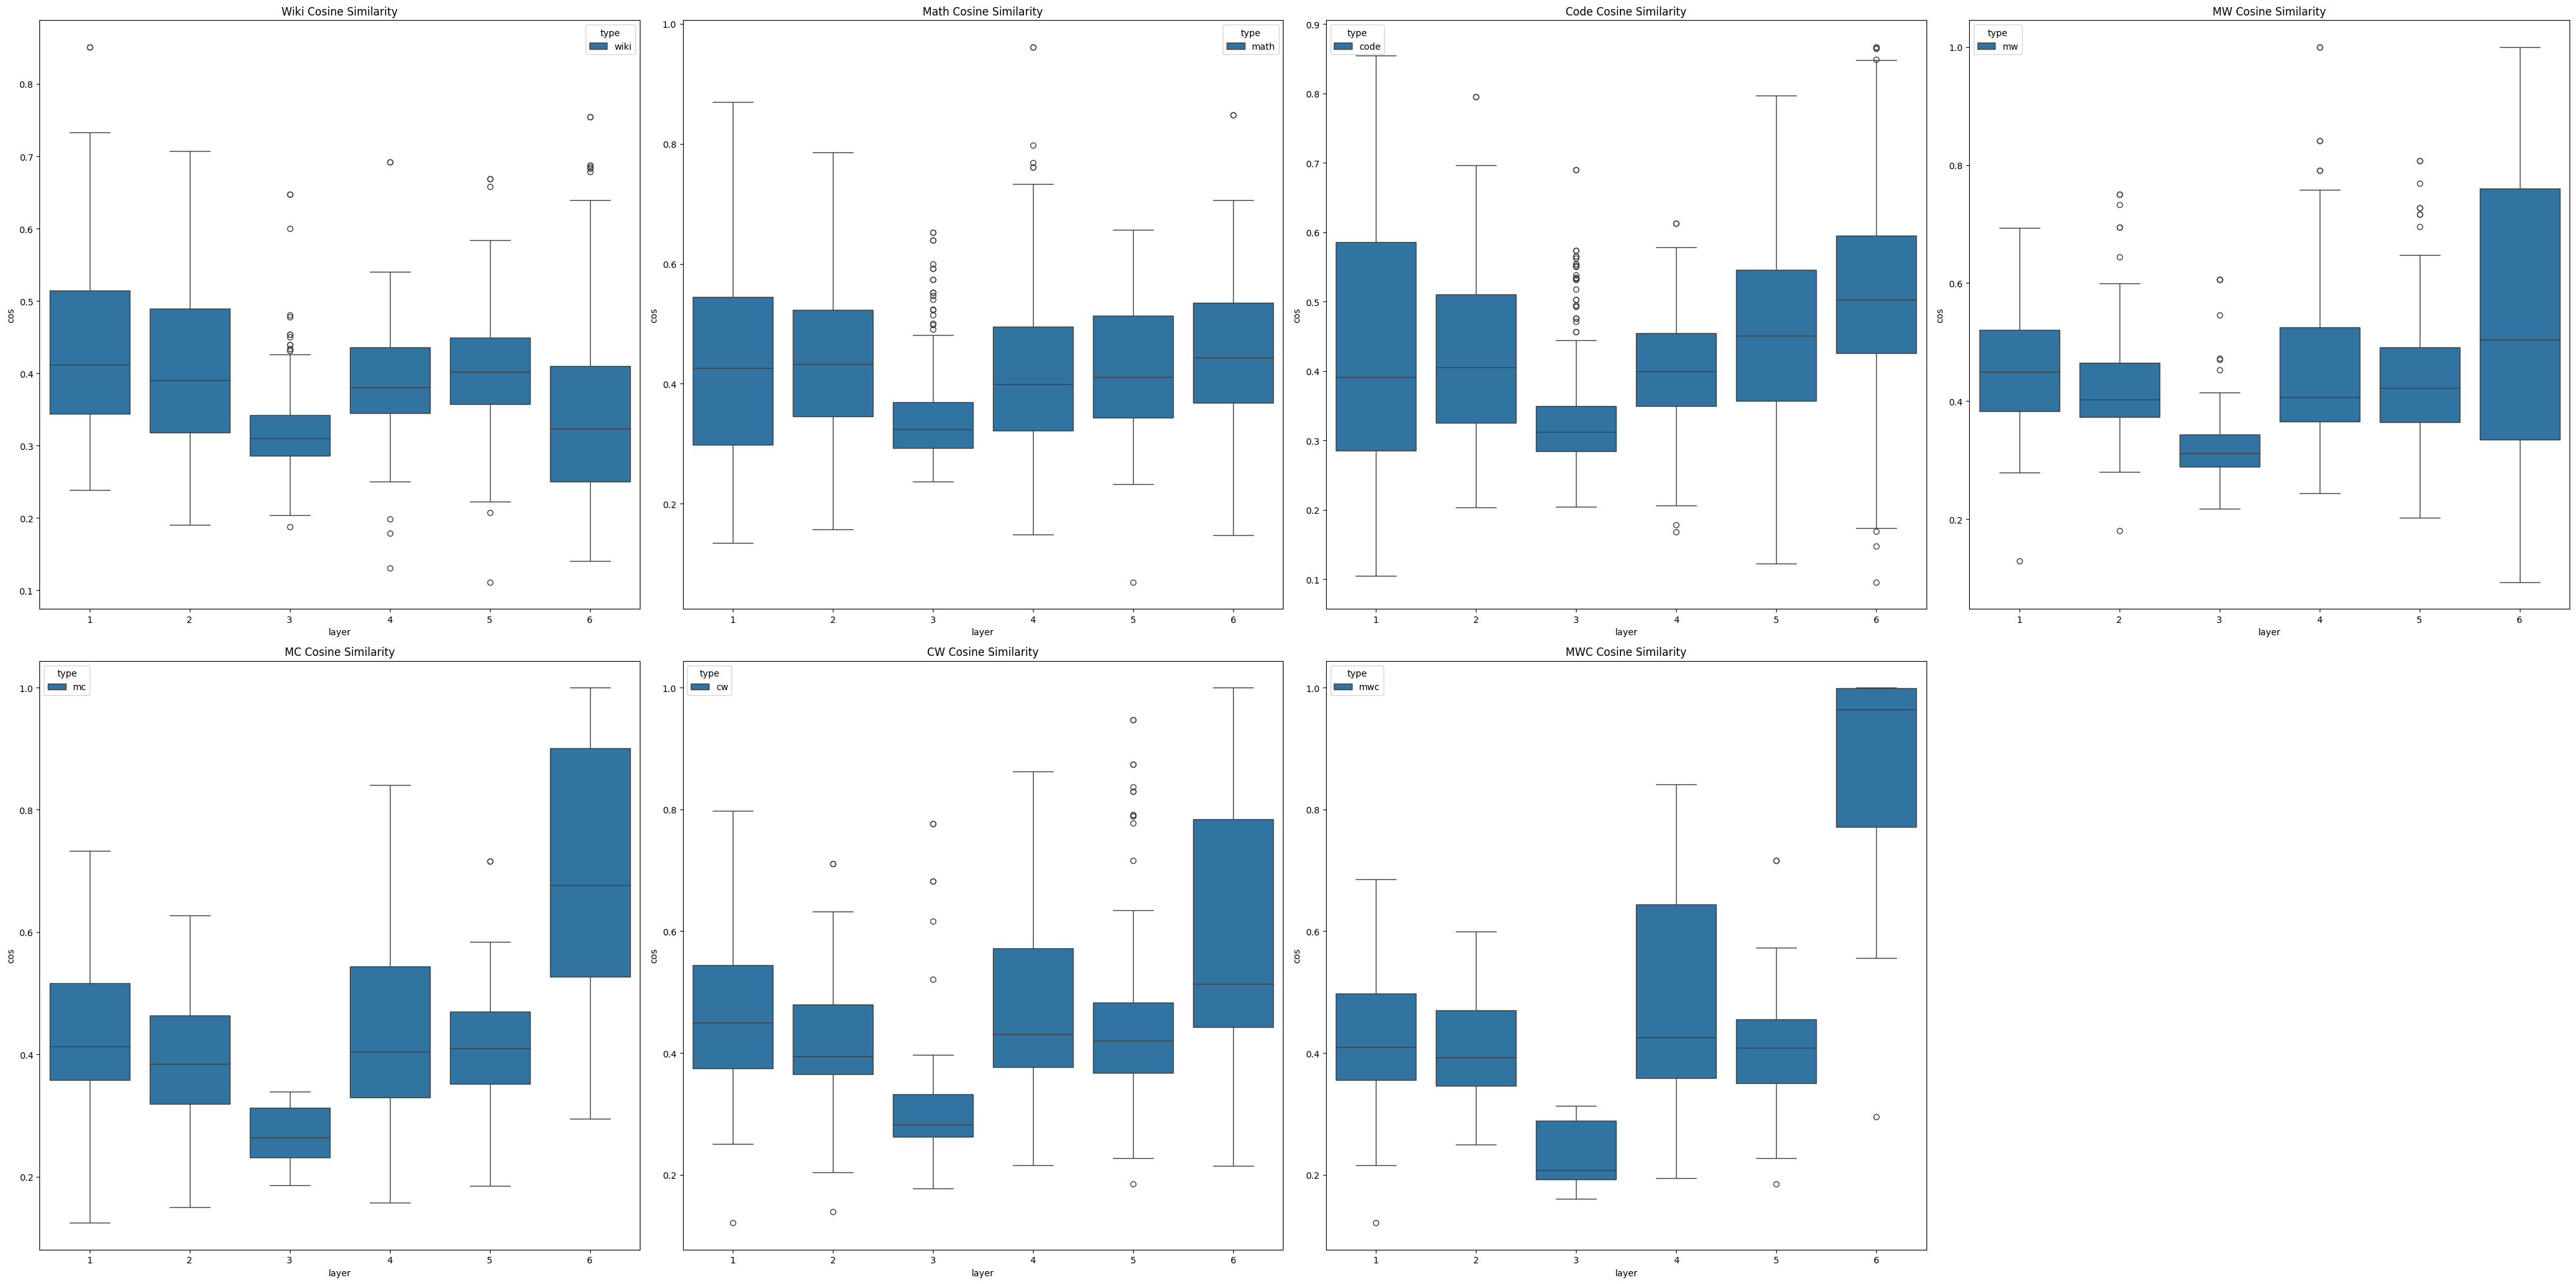

In [30]:
import matplotlib.pyplot as plt
wiki_stat = []
math_stat = []
code_stat = []
mwc_stat = []
mw_stat = []
cw_stat = []
mc_stat = []
top_num = 325
for layer in range(6):
    top_index_code = torch.topk(code_acts[layer], top_num).indices
    top_index_math = torch.topk(math_acts[layer+1], top_num).indices
    top_index_wiki = torch.topk(wiki_acts[layer+1], top_num).indices
    top_index_mc = np.intersect1d(top_index_code.cpu().numpy(), top_index_math.cpu().numpy())
    top_index_mw = np.intersect1d(top_index_math.cpu().numpy(), top_index_wiki.cpu().numpy())
    top_index_cw = np.intersect1d(top_index_code.cpu().numpy(), top_index_wiki.cpu().numpy())
    top_index = np.intersect1d(top_index_mc, top_index_mw)
    top_index_wiki = np.setdiff1d(top_index_wiki.cpu().numpy(), np.union1d(top_index_cw, top_index_mw))
    top_index_math = np.setdiff1d(top_index_math.cpu().numpy(), np.union1d(top_index_mc, top_index_mw))
    top_index_code = np.setdiff1d(top_index_code.cpu().numpy(), np.union1d(top_index_mc, top_index_cw))
    wiki_cs = get_cosine_similarity(saes[layer].W_dec[top_index_wiki, :], saes[layer].W_dec[top_index_wiki, :])
    math_cs = get_cosine_similarity(saes[layer].W_dec[top_index_math, :], saes[layer].W_dec[top_index_math, :])
    code_cs = get_cosine_similarity(saes[layer].W_dec[top_index_code, :], saes[layer].W_dec[top_index_code, :])
    mw_cs = get_cosine_similarity(saes[layer].W_dec[top_index_mw, :], saes[layer].W_dec[top_index_mw, :])
    mc_cs = get_cosine_similarity(saes[layer].W_dec[top_index_mc, :], saes[layer].W_dec[top_index_mc, :])
    cw_cs = get_cosine_similarity(saes[layer].W_dec[top_index_cw, :], saes[layer].W_dec[top_index_cw, :])
    mwc_cs = get_cosine_similarity(saes[layer].W_dec[top_index, :], saes[layer].W_dec[top_index, :])
    wiki_stat.append(pd.DataFrame({'cos': wiki_cs.fill_diagonal_(-100).max(1).values.cpu().numpy(), 'layer': layer+1, 'type': 'wiki'}))
    math_stat.append(pd.DataFrame({'cos': math_cs.fill_diagonal_(-100).max(1).values.cpu().numpy(), 'layer': layer+1, 'type': 'math'}))
    code_stat.append(pd.DataFrame({'cos': code_cs.fill_diagonal_(-100).max(1).values.cpu().numpy(), 'layer': layer+1, 'type': 'code'}))
    mw_stat.append(pd.DataFrame({'cos': mw_cs.fill_diagonal_(-100).max(1).values.cpu().numpy(), 'layer': layer+1, 'type': 'mw'}))
    mc_stat.append(pd.DataFrame({'cos': mc_cs.fill_diagonal_(-100).max(1).values.cpu().numpy(), 'layer': layer+1, 'type': 'mc'}))
    cw_stat.append(pd.DataFrame({'cos': cw_cs.fill_diagonal_(-100).max(1).values.cpu().numpy(), 'layer': layer+1, 'type': 'cw'}))
    mwc_stat.append(pd.DataFrame({'cos': mwc_cs.fill_diagonal_(-100).max(1).values.cpu().numpy(), 'layer': layer+1, 'type': 'mwc'}))

fig, axes = plt.subplots(2, 4, figsize=(40, 20))
fig.delaxes(axes[1, 3])

sns.boxplot(data=pd.concat(wiki_stat), x='layer', y='cos', hue='type', ax=axes[0,0])
axes[0,0].set_title('Wiki Cosine Similarity')

sns.boxplot(data=pd.concat(math_stat), x='layer', y='cos', hue='type', ax=axes[0,1])
axes[0,1].set_title('Math Cosine Similarity')

sns.boxplot(data=pd.concat(code_stat), x='layer', y='cos', hue='type', ax=axes[0,2])
axes[0,2].set_title('Code Cosine Similarity')

sns.boxplot(data=pd.concat(mw_stat), x='layer', y='cos', hue='type', ax=axes[0,3])
axes[0,3].set_title('MW Cosine Similarity')

sns.boxplot(data=pd.concat(mc_stat), x='layer', y='cos', hue='type', ax=axes[1,0])
axes[1,0].set_title('MC Cosine Similarity')

sns.boxplot(data=pd.concat(cw_stat), x='layer', y='cos', hue='type', ax=axes[1,1])
axes[1,1].set_title('CW Cosine Similarity')

sns.boxplot(data=pd.concat(mwc_stat), x='layer', y='cos', hue='type', ax=axes[1,2])
axes[1,2].set_title('MWC Cosine Similarity')

plt.tight_layout()
fig.savefig("../res/cos_sim/top_freq_vector_vector.pdf")
plt.show()

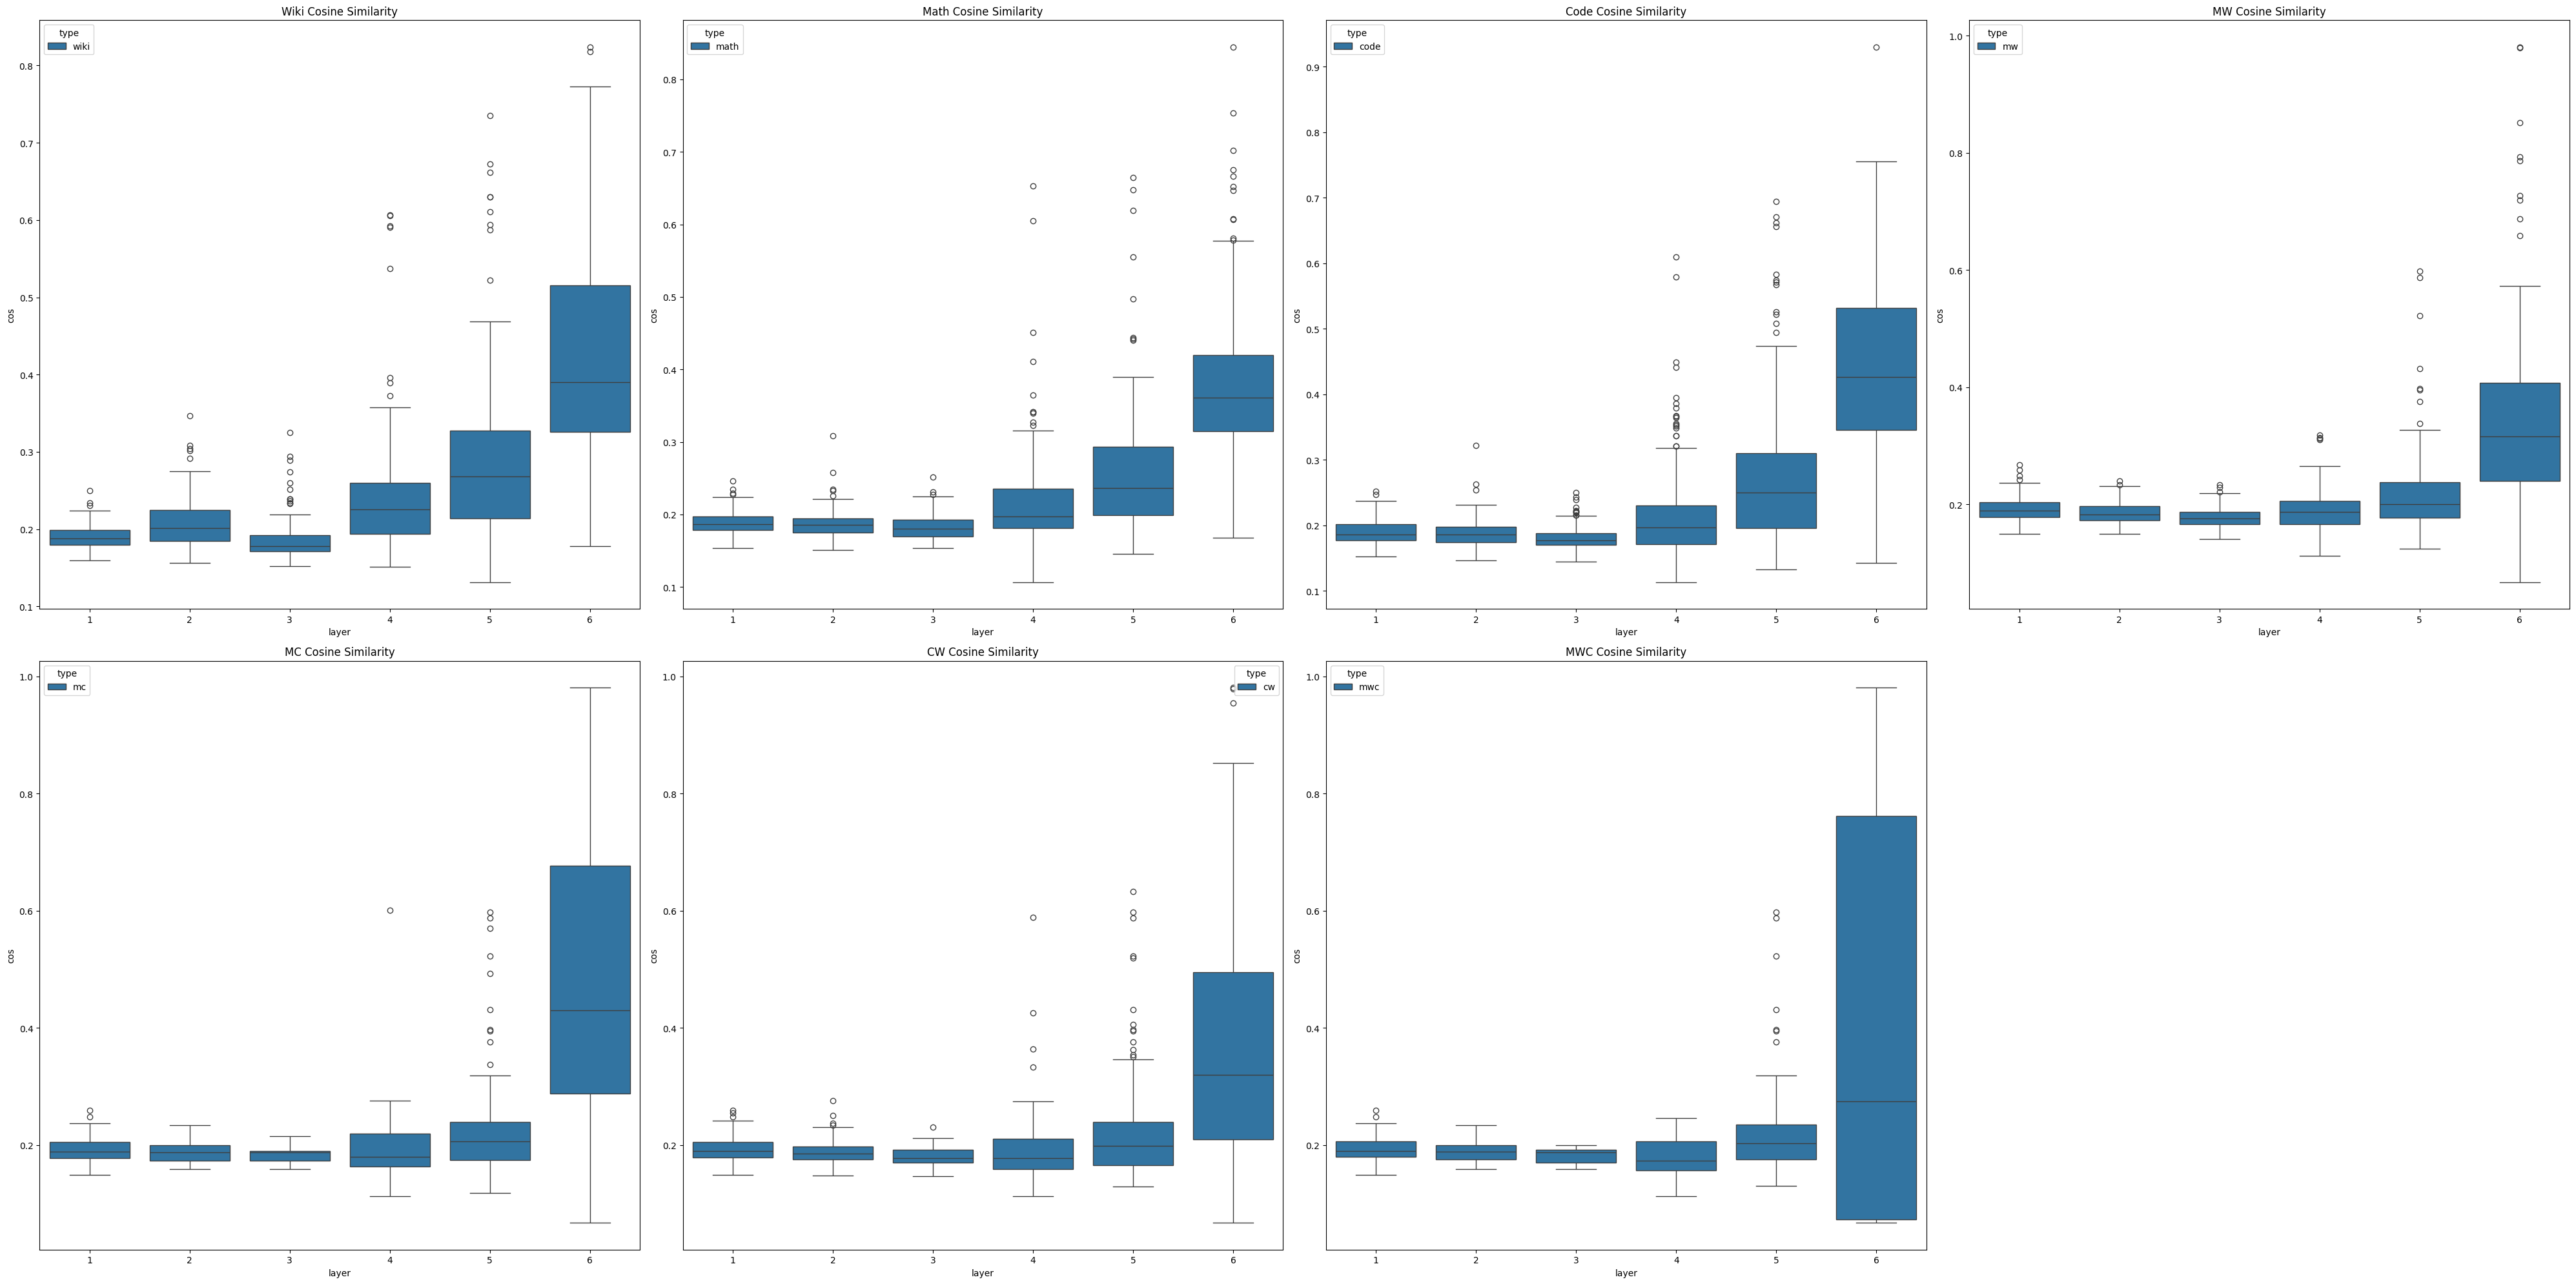

In [29]:
wiki_stat = []
math_stat = []
code_stat = []
mwc_stat = []
mw_stat = []
cw_stat = []
mc_stat = []
top_num = 325
for layer in range(6):
    top_index_code = torch.topk(code_acts[layer], top_num).indices
    top_index_math = torch.topk(math_acts[layer+1], top_num).indices
    top_index_wiki = torch.topk(wiki_acts[layer+1], top_num).indices
    top_index_mc = np.intersect1d(top_index_code.cpu().numpy(), top_index_math.cpu().numpy())
    top_index_mw = np.intersect1d(top_index_math.cpu().numpy(), top_index_wiki.cpu().numpy())
    top_index_cw = np.intersect1d(top_index_code.cpu().numpy(), top_index_wiki.cpu().numpy())
    top_index = np.intersect1d(top_index_mc, top_index_mw)
    top_index_wiki = np.setdiff1d(top_index_wiki.cpu().numpy(), np.union1d(top_index_cw, top_index_mw))
    top_index_math = np.setdiff1d(top_index_math.cpu().numpy(), np.union1d(top_index_mc, top_index_mw))
    top_index_code = np.setdiff1d(top_index_code.cpu().numpy(), np.union1d(top_index_mc, top_index_cw))
    wiki_cs = get_cosine_similarity(saes[layer].W_dec[top_index_wiki, :], model.unembed.W_U.T)
    math_cs = get_cosine_similarity(saes[layer].W_dec[top_index_math, :], model.unembed.W_U.T)
    code_cs = get_cosine_similarity(saes[layer].W_dec[top_index_code, :], model.unembed.W_U.T)
    mw_cs = get_cosine_similarity(saes[layer].W_dec[top_index_mw, :], model.unembed.W_U.T)
    mc_cs = get_cosine_similarity(saes[layer].W_dec[top_index_mc, :], model.unembed.W_U.T)
    cw_cs = get_cosine_similarity(saes[layer].W_dec[top_index_cw, :], model.unembed.W_U.T)
    mwc_cs = get_cosine_similarity(saes[layer].W_dec[top_index, :], model.unembed.W_U.T)
    wiki_stat.append(pd.DataFrame({'cos': wiki_cs.fill_diagonal_(-100).max(1).values.cpu().numpy(), 'layer': layer+1, 'type': 'wiki'}))
    math_stat.append(pd.DataFrame({'cos': math_cs.fill_diagonal_(-100).max(1).values.cpu().numpy(), 'layer': layer+1, 'type': 'math'}))
    code_stat.append(pd.DataFrame({'cos': code_cs.fill_diagonal_(-100).max(1).values.cpu().numpy(), 'layer': layer+1, 'type': 'code'}))
    mw_stat.append(pd.DataFrame({'cos': mw_cs.fill_diagonal_(-100).max(1).values.cpu().numpy(), 'layer': layer+1, 'type': 'mw'}))
    mc_stat.append(pd.DataFrame({'cos': mc_cs.fill_diagonal_(-100).max(1).values.cpu().numpy(), 'layer': layer+1, 'type': 'mc'}))
    cw_stat.append(pd.DataFrame({'cos': cw_cs.fill_diagonal_(-100).max(1).values.cpu().numpy(), 'layer': layer+1, 'type': 'cw'}))
    mwc_stat.append(pd.DataFrame({'cos': mwc_cs.fill_diagonal_(-100).max(1).values.cpu().numpy(), 'layer': layer+1, 'type': 'mwc'}))
fig, axes = plt.subplots(2, 4, figsize=(40, 20))
fig.delaxes(axes[1, 3])

sns.boxplot(data=pd.concat(wiki_stat), x='layer', y='cos', hue='type', ax=axes[0,0])
axes[0,0].set_title('Wiki Cosine Similarity')

sns.boxplot(data=pd.concat(math_stat), x='layer', y='cos', hue='type', ax=axes[0,1])
axes[0,1].set_title('Math Cosine Similarity')

sns.boxplot(data=pd.concat(code_stat), x='layer', y='cos', hue='type', ax=axes[0,2])
axes[0,2].set_title('Code Cosine Similarity')

sns.boxplot(data=pd.concat(mw_stat), x='layer', y='cos', hue='type', ax=axes[0,3])
axes[0,3].set_title('MW Cosine Similarity')

sns.boxplot(data=pd.concat(mc_stat), x='layer', y='cos', hue='type', ax=axes[1,0])
axes[1,0].set_title('MC Cosine Similarity')

sns.boxplot(data=pd.concat(cw_stat), x='layer', y='cos', hue='type', ax=axes[1,1])
axes[1,1].set_title('CW Cosine Similarity')

sns.boxplot(data=pd.concat(mwc_stat), x='layer', y='cos', hue='type', ax=axes[1,2])
axes[1,2].set_title('MWC Cosine Similarity')

plt.tight_layout()
fig.savefig("../res/cos_sim/top_freq_vector_unembed.pdf")